In [88]:
import torch
import torch.nn as nn
import torchvision 
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression

import pandas as pd 
import numpy as np
import cvxpy as cp
import math
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from random import sample
import random

from wilds import get_dataset
from wilds.common.data_loaders import get_train_loader

from conditionalconformal.synthetic_data import generate_cqr_data
from conditionalconformal.condconf import setup_cvx_problem_calib
from temperatureScaling import torch_ts

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load Data

In [4]:
### functions for loading in pretrained neural network

def stripPrefix(stateDict):
    returnDict = {}
    for key in stateDict:
        newKey = key[6:]
        returnDict[newKey] = stateDict[key]
    return returnDict

def myLoad(module, path, device=None):
    if device is not None:
        state = torch.load(path, map_location=device)
    else:
        state = torch.load(path)
    state = stripPrefix(state['algorithm'])
    
    module.load_state_dict(state)
    return 


In [9]:
### Load in pretrained neural network
dimOut = 1139
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

constructor = torchvision.models.resnet50
model = constructor()
dimFeatures = model.fc.in_features
lastLayer = nn.Linear(dimFeatures,dimOut)
model.d_out = dimFeatures
model.fc = lastLayer


rx1Model = model.to(device)
myLoad(rx1Model,
            'data/rxrx1_seed_0_epoch_best_model.pth',
            device=device)
featurizer = rx1Model
classifier = rx1Model.fc
featurizer.fc = nn.Identity()

rx1Model = nn.Sequential(*(featurizer,classifier))

rx1Model.eval()
featurizer.eval()
classifier.eval()

Linear(in_features=2048, out_features=1139, bias=True)

In [10]:
### Normalize images for neural net evaluation. Code taken from WILDS repository
def initializeRxrx1Transform(): 
    def standardize(x: torch.Tensor) -> torch.Tensor:
        mean = x.mean(dim=(1, 2))
        std = x.std(dim=(1, 2))
        std[std == 0.] = 1.
        return TF.normalize(x, mean, std)
    t_standardize = transforms.Lambda(lambda x: standardize(x))

    transforms_ls = [
        transforms.ToTensor(),
        t_standardize,
    ]
    return transforms.Compose(transforms_ls)

myTransform = initializeRxrx1Transform()

torch.manual_seed(1)
np.random.seed(1)
random.seed(1)

### Load in data from WILDS repository
rx1Data = get_dataset(dataset="rxrx1", download=False)
rx1TestImages = rx1Data.get_subset(
    "test",
    transform = myTransform
)
metaData = pd.read_csv('data/rxrx1_v1.0/metadata.csv')
metaData = metaData[metaData['dataset'] == 'test']

In [16]:
n = len(rx1TestImages) 

### Get feature representation from pretrained neural network
featureMat = np.zeros((n,2048))
for i in range(n):
    featureMat[i,:] = featurizer(rx1TestImages[i][0].reshape((1,3,256,256)).to(device)).cpu().detach().numpy()[0,:]

### reshape meta data
metaDataFinal = np.zeros((n,len(rx1TestImages[0][2])))

### extract y values
y = np.zeros(n)
for i in range(n):
    metaDataFinal[i,:] = rx1TestImages[i][2].numpy()
    y[i] = rx1TestImages[i][1].numpy()
    
### get probabilities output by pretrained neural network
rawProbMat = np.zeros((n,1139))
for i in range(n):
    rawProbMat[i,:] = classifier(torch.from_numpy(featureMat[i,:].reshape(1,2048)).to(torch.float32).to(device)).cpu().detach().numpy()[0,:]


In [17]:
### Form train-calibration-test split
trainingIndices = sample(range(len(featureMat)),int(len(featureMat)/2))
featureSubset = sample(range(len(trainingIndices)),int(len(trainingIndices)/2))
indicesFeatures = np.array(range(len(featureMat)))[trainingIndices][featureSubset]
indicesCalibration = np.delete(np.array(range(len(featureMat)))[trainingIndices],featureSubset)
indicesTest =  np.delete(range(len(featureMat)),trainingIndices)

In [20]:
### Functions for computing conformity scores
from temperatureScaling import torch_ts

def softmax(x):
    ex = np.exp(x - np.max(x))
    return ex / ex.sum()

def classConfScore(probs,y):
    return sum(probs[probs > probs[int(y)]])

def computeConformityScores(XTrain,XTest,yTrain,yTest):
    T = torch_ts(XTrain,yTrain)
    scaleFactor = T.detach().numpy()
    
    normXtrain = np.apply_along_axis(softmax,1,XTrain/scaleFactor)
    normXtest = np.apply_along_axis(softmax,1,XTest/scaleFactor)

    scoresTrain = np.zeros(len(yTrain))
    for i in range(len(yTrain)):
        scoresTrain[i] = classConfScore(normXtrain[i,:],yTrain[i])

    scoresTest = np.zeros(len(yTest))
    for i in range(len(yTest)):
        scoresTest[i] = classConfScore(normXtest[i,:],yTest[i])
    return scoresTrain, scoresTest

### Compute conformity scores
scoresCal, scoresTest = computeConformityScores(rawProbMat[indicesCalibration,:]
                                                        ,rawProbMat[indicesTest,:],
                                                        y[indicesCalibration],y[indicesTest])

### Run Experiments

#### Constructing Features Using Estimated Probabilities

In [ ]:
### Run a multinomial logistic regression

### Use cross validation to select regularization parameter
def cvForFeatures(X, y, numCs = 20, minC = 0.001, maxC = 0.1): 
    folds = KFold(n_splits = 5, shuffle = True)
    Cvalues = np.linspace(minC,maxC,numCs)
    losses = np.zeros(numCs)
    count = 0
    for C in tqdm(Cvalues):
        model = LogisticRegression(multi_class='multinomial', C = C, max_iter=5000)
        for i, (trainPoints, testPoints) in enumerate(folds.split(X)):
            reg = model.fit(X[trainPoints,:],y[trainPoints])
            predictedProbs = reg.predict_proba(X[testPoints,:])
            for j in range(len(testPoints)):
                losses[count] = losses[count] - np.log(predictedProbs[j,int(y[testPoints][j])])/len(testPoints)
        count = count + 1
        
    return Cvalues, losses

def computeFeatures(XTrain, XCal, XTest, yTrain, Cvalues, losses):
    model = LogisticRegression(multi_class='multinomial', C = Cvalues[np.argmin(losses)], max_iter=5000)
    reg = model.fit(XTrain, yTrain)

    featuresCal = reg.predict_proba(XCal)
    featuresTest = reg.predict_proba(XTest)
    
    return featuresCal, featuresTest


experiment = metaData['experiment'].copy().to_numpy()
count = 0
for i in np.unique(experiment):
    experiment[experiment == i] = count
    count = count + 1
experiment = experiment.astype('int')

Cvalues, losses = cvForFeatures(featureMat[indicesFeatures,:],experiment[indicesFeatures],
                                                numCs = 20, minC = 0.001, maxC = 0.1)
plt.plot(Cvalues,losses)

finalFeaturesCal, finalFeaturesTest = computeFeatures(featureMat[indicesFeatures,:],
                                                                           featureMat[indicesCalibration,:],
                                                                           featureMat[indicesTest,:],
                                                                           experiment[indicesFeatures], Cvalues, losses)


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 13/20 [59:41<39:32, 338.93s/it]

In [92]:
### Check if split conformal and our conditional calibration method cover the test points
def computeCoverages(XCal, scoresCal, XTest, scoresTest, alpha):
    qSplit = np.quantile(scoresCal,[math.ceil((1-alpha) * (len(scoresCal) + 1)) / len(scoresCal)])
    coveragesSplit = scoresTest <= qSplit

    coveragesCond = np.zeros(len(XTest))
    for i in tqdm(range(len(XTest))):
        prob = setup_cvx_problem_calib(1-alpha,None,
                                               np.concatenate((scoresCal,np.array([scoresTest[i]]))), np.vstack((XCal,XTest[i,:])),{})
        if "MOSEK" in cp.installed_solvers():
            prob.solve(solver="MOSEK")
        else:
            prob.solve()
        coveragesCond[i] = scoresTest[i] <= XTest[i,:]@prob.constraints[2].dual_value

    return coveragesSplit, coveragesCond

coveragesSplit, coveragesCond = computeCoverages(finalFeaturesCal, scoresCal,
                                                        finalFeaturesTest, scoresTest, alpha = 0.1)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17216/17216 [34:11<00:00,  8.39it/s]


In [93]:
### Organize results into data frames for plotting
def constructCoverageDf(coveragesSplit, coveragesCond, subgrouping, name):
    covDf = pd.DataFrame({name: ['Marginal','Marginal'], 'Type': ['Split Conformal','Conditional Calibration'],
                          'Coverage': [np.mean(coveragesSplit),
                                       np.mean(coveragesCond)],
                         'SampleSize': [len(coveragesSplit),
                                       len(coveragesCond)]})
    for i in np.unique(subgrouping):
        newDf = pd.DataFrame({name: [int(i)+1,int(i)+1], 'Type': ['Split Conformal','Conditional Calibration'],
                              'Coverage': [np.mean(coveragesSplit[subgrouping == i]),
                                           np.mean(coveragesCond[subgrouping == i])],
                             'SampleSize': [sum(subgrouping == i),
                                           sum(subgrouping == i)]})
        covDf = pd.concat([covDf,newDf])
    covDf['error'] = 1.96*np.sqrt(covDf['Coverage']*(1-covDf['Coverage'])/covDf['SampleSize'])
    
    return covDf

count = 0
for name in np.unique(metaData['cell_type']):
    metaData.loc[metaData['cell_type'] == name, 'cell_type'] = count
    count = count + 1
count = 0
for name in np.unique(metaData['experiment']):
    metaData.loc[metaData['experiment'] == name, 'experiment'] = count
    count = count + 1

covDfCells= constructCoverageDf(coveragesSplit, coveragesCond,
                                        metaData['ct'].iloc[indicesTest],
                                        name = 'Cell Type')

covDfExperiments = constructCoverageDf(coveragesSplit, coveragesCond,
                                              metaData['experiment'].iloc[indicesTest],
                                              name = 'Experiment')

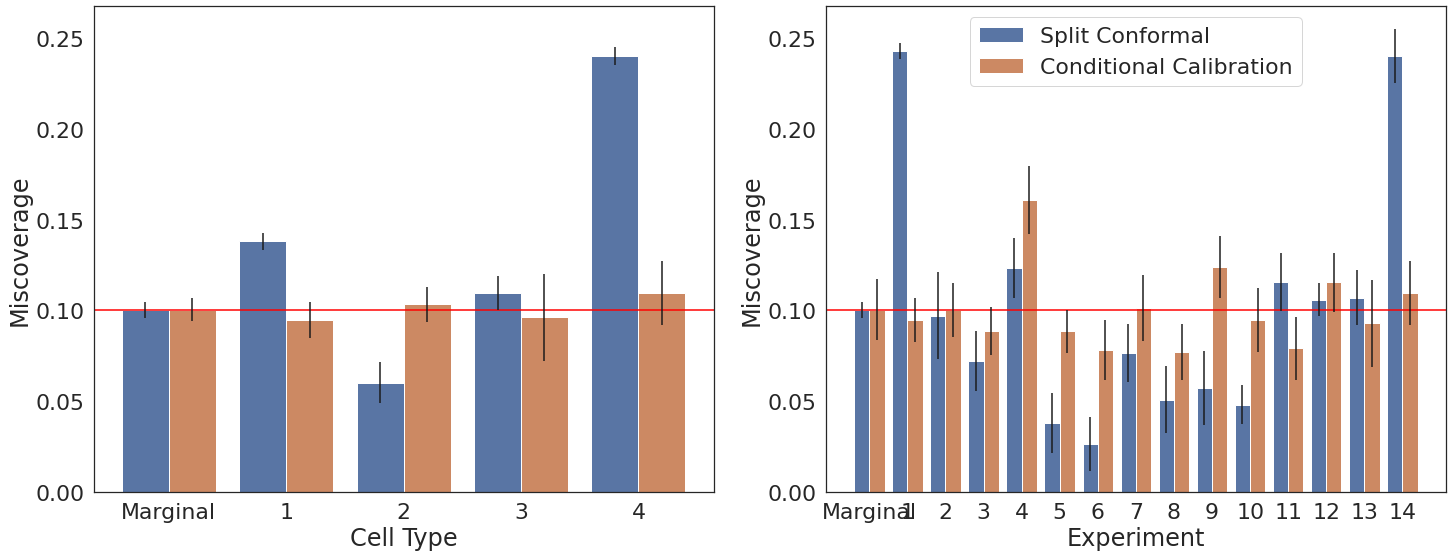

In [94]:
### Plot Results
covDfExperiments['Miscoverage'] = 1-covDfExperiments['Coverage']
covDfCells['Miscoverage'] = 1-covDfCells['Coverage']
sns.set(rc={'figure.figsize':(20.7,8.27)})
sns.set(font_scale=2)
sns.set_style(style='white')

fig = plt.figure()

ax1 = fig.add_subplot(1, 2, 1)
f = sns.barplot(covDfCells,x='Cell Type',y='Miscoverage',hue='Type',ax=ax1)
f.axhline(0.1, color='red')
x_coords = [p.get_x() + 0.5 * p.get_width() for p in f.patches]
y_coords = [p.get_height() for p in f.patches]
f.errorbar(x=x_coords, y=y_coords, yerr=covDfCells['error'], fmt="none", c="k")
plt.legend([],[], frameon=False)

ax2 = fig.add_subplot(1, 2, 2, sharey = ax1)
f2 = sns.barplot(covDfExperiments,x='Experiment',y='Miscoverage',hue='Type',ax=ax2)
f2.axhline(0.1, color='red')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

x_coords = [p.get_x() + 0.5 * p.get_width() for p in f2.patches]
y_coords = [p.get_height() for p in f2.patches]
f2.errorbar(x=x_coords, y=y_coords, yerr=covDfExperiments['error'], fmt="none", c="k")
plt.legend(title='')
plt.legend(loc='upper center')

plt.tight_layout()

### PCA Experiment

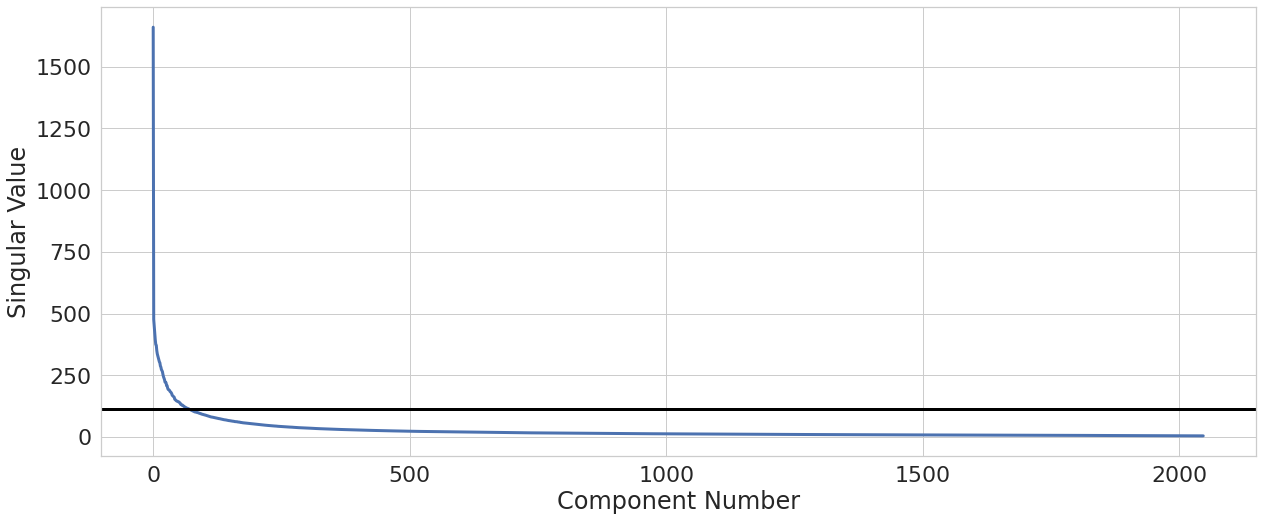

In [108]:
### Compute principle components
from scipy.linalg import svd

U, S, VT = svd(featureMat[indicesFeatures,:])

### Make scree plot
sns.set(rc={'figure.figsize':(20.7,8.27)})
sns.set(font_scale=2)
sns.set_style(style='whitegrid')

plt.plot(range(len(S)),S, lw=3)
plt.xlabel("Component Number")
plt.ylabel("Singular Value")
plt.axhline(S[70],color='black',lw=3)

### Construct features
finalFeaturesCalPCA = featureMat[indicesCalibration,:] @ (VT.T[:,0:70])
finalFeaturesTestPCA = featureMat[indicesTest,:] @ (VT.T[:,0:70])
finalFeaturesCalPCA = np.column_stack((finalFeaturesCalPCA,np.ones(len(finalFeaturesCalPCA))))
finalFeaturesTestPCA = np.column_stack((finalFeaturesTestPCA,np.ones(len(finalFeaturesTestPCA))))


In [ ]:
### Evaluate coverage
coveragesSplitPCA, coveragesCondPCA = computeCoverages(finalFeaturesCalPCA, scoresCal,
                                                        finalFeaturesTestPCA, scoresTest, alpha = 0.1)

  1%|█▎                                                                                                                                                                                              | 114/17216 [00:50<2:06:54,  2.25it/s]

In [ ]:
### Organize results into dataframs for plotting
covDfCellsPCA = constructCoverageDf(coveragesSplitPCA, coveragesCondPCA,
                                      metaData['cell_type'].iloc[indicesTest], name = 'Cell Type')

covDfExperimentsPCA = constructCoverageDf(coveragesSplitPCA, coveragesCondPCA, 
                                            metaData['experiment'].iloc[indicesTest], name = 'Experiment')

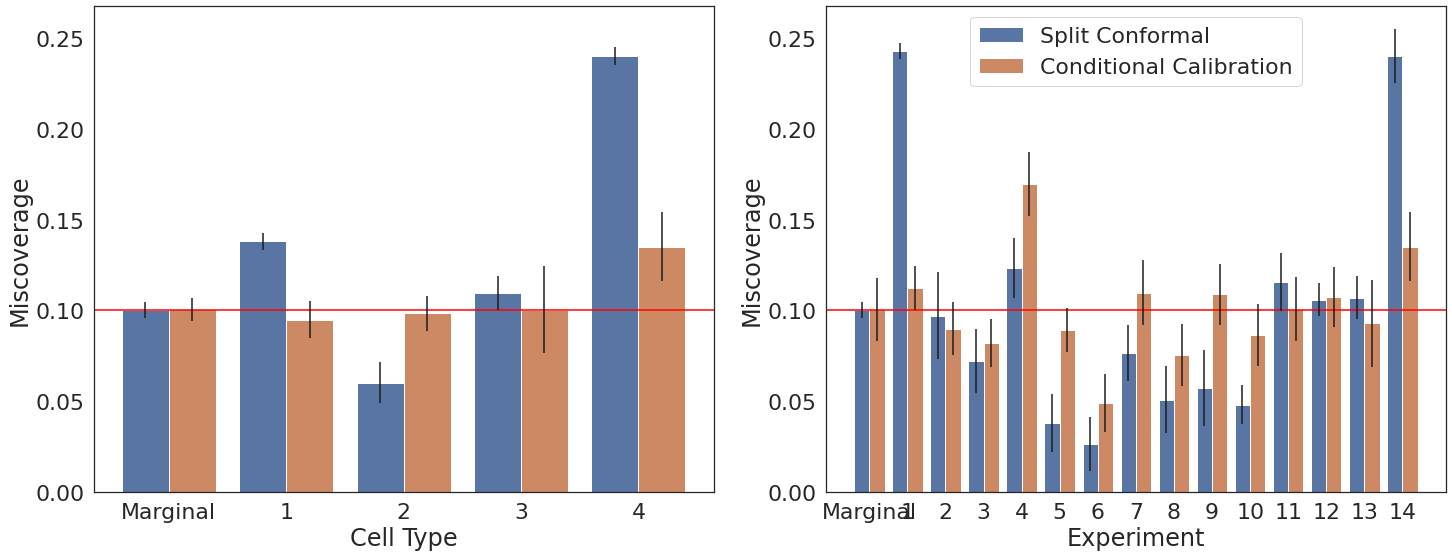

In [112]:
### Plot Results
covDfCellsPCA['Miscoverage'] = 1-covDfCellsPCA['Coverage']
covDfExperimentsPCA['Miscoverage'] = 1-covDfExperimentsPCA['Coverage']

sns.set(rc={'figure.figsize':(20.7,8.27)})
sns.set(font_scale=2)
sns.set_style(style='white')

fig = plt.figure()

ax1 = fig.add_subplot(1, 2, 1)
f = sns.barplot(covDfCellsPCA,x='Cell Type',y='Miscoverage',hue='Type',ax=ax1)
f.axhline(0.1, color='red')
plt.legend([],[], frameon=False)

x_coords = [p.get_x() + 0.5 * p.get_width() for p in f.patches]
y_coords = [p.get_height() for p in f.patches]
f.errorbar(x=x_coords, y=y_coords, yerr=covDfCellsPCA['error'], fmt="none", c="k")

ax2 = fig.add_subplot(1, 2, 2, sharey = ax1)
f2 = sns.barplot(covDfExperimentsPCA,x='Experiment',y='Miscoverage',hue='Type',ax=ax2)
f2.axhline(0.1, color='red')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

x_coords = [p.get_x() + 0.5 * p.get_width() for p in f2.patches]
y_coords = [p.get_height() for p in f2.patches]
f2.errorbar(x=x_coords, y=y_coords, yerr=covDfExperimentsPCA['error'], fmt="none", c="k")
plt.legend([],[], frameon=False)
plt.legend(title='')
plt.legend(loc='upper center')

plt.tight_layout()